In [1]:
import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy import stats
import datetime

import pyodbc

sys.path.insert(0, os.path.realpath('..'))
import Utilities_config

#---------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_dt

In [2]:
def substring_in_all(substr, arr):
    for a in arr:
        if a.find(substr)<0:
            return False
    return True


def find_longest_substring_shared_by_all(arr):
    # Designed for case where table name prepended to each column name
    # when calling e.g. pd.run_sql
    # e.g., columns = ['reading_ivl_nonvee.serialnumber', 'reading_ivl_nonvee.starttimeperiod', ...
    #                  'reading_ivl_nonvee.value']
    #
    # With this in mind, let's try to simplest case first before running into full blown method.
    #   By simplest case, I mean find the longest common string between the first each of the others,
    #   and if that common string is found in all, return it
    for i in range(1, len(arr)):
        longest_common = Utilities.find_longest_shared_substring(arr[0], arr[i])
        if substring_in_all(longest_common, arr):
            return longest_common

    # Simple method did not work, so run full blown
    str0 = arr[0]
    res = ''
    for i in range(len(str0)+1):
        for j in range(i+1, len(str0)+1):
            if substring_in_all(str0[i:j], arr) and len(str0[i:j])>len(res):
                res = str0[i:j]
    return res


def remove_longest_substring_shared_by_all(arr):
    common_subst = find_longest_substring_shared_by_all(arr)
    if len(common_subst)==0:
        return arr
    return_arr = []
    for a in arr:
        idx = a.find(common_subst)
        return_arr.append(a[:idx]+a[idx+len(common_subst):])
    return return_arr


def remove_longest_substring_shared_by_all_columns_in_df(df, inplace=True):
    columns_org = df.columns.tolist()
    columns_new = remove_longest_substring_shared_by_all(columns_org)
    if columns_org==columns_new:
        return df
    assert(len(columns_org)==len(columns_new))
    cols_rename_dict = dict(zip(columns_org, columns_new))
    if inplace:
        df.rename(columns=cols_rename_dict, inplace=True)
    else:
        df = df.rename(columns=cols_rename_dict, inplace=False)
    return df

In [3]:
run_local_data = False

In [5]:
if not run_local_data:
    conn = Utilities.get_athena_prod_aws_connection()
    #--------------------------------------------------------
    # sql = 'Show partitions default.meter_premise'

    # sql = ("Select * from usage_nonvee.reading_ivl_nonvee \
    #        where aep_opco = 'oh' \
    #        and aep_usage_dt = '2021-10-12' \
    #        and aep_derived_uom = 'KWH' \
    #        and serialnumber = '436403564'")


    cols_of_interest = ['serialnumber', 'starttimeperiod', 'endtimeperiod', 'aep_endtime_utc', 
                        'timezoneoffset', 'aep_srvc_qlty_idntfr', 'value']
    # sql = ("Select {} \
    #        from usage_nonvee.reading_ivl_nonvee \
    #        where aep_opco = 'oh' \
    #        and aep_usage_dt = '2021-10-12' \
    #        and aep_derived_uom = 'KWH' \
    #        and serialnumber = '436403564'").format(','.join(cols_of_interest))

    serial_number_0 = 436403564
    n_serial_numbers = 10
    serial_numbers = np.arange(serial_number_0, serial_number_0+n_serial_numbers)

    opco_ids = ['oh']

    sql = ("Select {} \
           from usage_nonvee.reading_ivl_nonvee \
           where aep_opco IN ({}) \
           and aep_usage_dt = '2021-10-12' \
           and aep_derived_uom = 'KWH' \
           and serialnumber IN ({})").format(','.join(cols_of_interest), 
                                             ','.join(["'{}'".format(x) for x in opco_ids]), 
                                             ','.join(["'{}'".format(x) for x in serial_numbers]))
    #--------------------------------------------------------
    df_full = pd.read_sql(sql, conn)
    
    #df_full.to_csv(os.path.join(Utilities.get_local_data_dir(), r'usage_nonvee.csv'), index=False)

In [6]:
if run_local_data:
    df_full = pd.read_csv(os.path.join(Utilities.get_local_data_dir(), r'usage_nonvee.csv'))

In [7]:
print(f'df_full.shape = {df_full.shape}')

df_full.shape = (1728, 7)


In [8]:
df_full.columns

Index(['reading_ivl_nonvee.serialnumber', 'reading_ivl_nonvee.starttimeperiod',
       'reading_ivl_nonvee.endtimeperiod',
       'reading_ivl_nonvee.aep_endtime_utc',
       'reading_ivl_nonvee.timezoneoffset',
       'reading_ivl_nonvee.aep_srvc_qlty_idntfr', 'reading_ivl_nonvee.value'],
      dtype='object')

In [9]:
df_full['reading_ivl_nonvee.serialnumber'].unique()

array(['436403564', '436403565', '436403568', '436403569', '436403571',
       '436403572', '436403573', '436403570', '436403567'], dtype=object)

In [10]:
# common_col_name = 'reading_ivl_nonvee.'
# cols_rename_dict = {x:x[len(common_col_name):] if x.find(common_col_name)>-1 else x 
#                     for x in df_full.columns}
# df_full = df_full.rename(columns=cols_rename_dict)


df_full = remove_longest_substring_shared_by_all_columns_in_df(df_full)

In [11]:
df_full.columns

Index(['serialnumber', 'starttimeperiod', 'endtimeperiod', 'aep_endtime_utc',
       'timezoneoffset', 'aep_srvc_qlty_idntfr', 'value'],
      dtype='object')

In [12]:
df_full.head()

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_srvc_qlty_idntfr,value
0,436403564,2021-10-12T17:45:00-04:00,2021-10-12T18:00:00-04:00,1634076000,-04:00,DELIVERED,4.014
1,436403565,2021-10-12T16:15:00-04:00,2021-10-12T16:30:00-04:00,1634070600,-04:00,DELIVERED,0.000
2,436403568,2021-10-12T02:45:00-04:00,2021-10-12T03:00:00-04:00,1634022000,-04:00,RECEIVED,0.000
3,436403568,2021-10-12T05:00:00-04:00,2021-10-12T05:15:00-04:00,1634030100,-04:00,DELIVERED,1.902
4,436403569,2021-10-12T03:45:00-04:00,2021-10-12T04:00:00-04:00,1634025600,-04:00,RECEIVED,0.000


In [13]:
df_full['aep_srvc_qlty_idntfr'].unique()

array(['DELIVERED', 'RECEIVED'], dtype=object)

In [14]:
cols_of_interest = ['serialnumber', 'starttimeperiod', 'endtimeperiod', 'aep_endtime_utc', 'timezoneoffset', 'aep_srvc_qlty_idntfr', 'value']
df = df_full[cols_of_interest].copy()
df['aep_endtime_utc'] = df['aep_endtime_utc'].astype(int)

In [15]:
df[df['aep_endtime_utc']==1634052600]

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_srvc_qlty_idntfr,value
12,436403573,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,RECEIVED,0.000
45,436403570,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,DELIVERED,1.766
72,436403568,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,RECEIVED,0.000
143,436403570,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,RECEIVED,0.000
641,436403569,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,RECEIVED,0.000
834,436403567,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,RECEIVED,0.000
841,436403565,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,RECEIVED,0.000
882,436403567,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,DELIVERED,0.850
951,436403565,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,DELIVERED,0.000
976,436403572,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,DELIVERED,0.138


In [16]:
df.sort_values(by='aep_endtime_utc')

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_srvc_qlty_idntfr,value
954,436403568,2021-10-12T00:00:00-04:00,2021-10-12T00:15:00-04:00,1634012100,-04:00,DELIVERED,3.452
1317,436403569,2021-10-12T00:00:00-04:00,2021-10-12T00:15:00-04:00,1634012100,-04:00,RECEIVED,0.000
1373,436403572,2021-10-12T00:00:00-04:00,2021-10-12T00:15:00-04:00,1634012100,-04:00,DELIVERED,0.140
1510,436403572,2021-10-12T00:00:00-04:00,2021-10-12T00:15:00-04:00,1634012100,-04:00,RECEIVED,0.000
1156,436403567,2021-10-12T00:00:00-04:00,2021-10-12T00:15:00-04:00,1634012100,-04:00,RECEIVED,0.000
...,...,...,...,...,...,...,...
1615,436403572,2021-10-12T23:45:00-04:00,2021-10-13T00:00:00-04:00,1634097600,-04:00,DELIVERED,0.146
182,436403573,2021-10-12T23:45:00-04:00,2021-10-13T00:00:00-04:00,1634097600,-04:00,RECEIVED,0.000
1068,436403565,2021-10-12T23:45:00-04:00,2021-10-13T00:00:00-04:00,1634097600,-04:00,RECEIVED,0.000
34,436403573,2021-10-12T23:45:00-04:00,2021-10-13T00:00:00-04:00,1634097600,-04:00,DELIVERED,0.150


In [17]:
df_del = df[df['aep_srvc_qlty_idntfr']=='DELIVERED']
df_rec = df[df['aep_srvc_qlty_idntfr']=='RECEIVED']

df_del = df_del.rename(columns={'value':'value_delivered'})
df_rec = df_rec.rename(columns={'value':'value_received'})

df_del = df_del.drop(columns=['aep_srvc_qlty_idntfr'])
df_rec = df_rec.drop(columns=['aep_srvc_qlty_idntfr'])

In [18]:
df_del

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,value_delivered
0,436403564,2021-10-12T17:45:00-04:00,2021-10-12T18:00:00-04:00,1634076000,-04:00,4.014
1,436403565,2021-10-12T16:15:00-04:00,2021-10-12T16:30:00-04:00,1634070600,-04:00,0.000
3,436403568,2021-10-12T05:00:00-04:00,2021-10-12T05:15:00-04:00,1634030100,-04:00,1.902
5,436403569,2021-10-12T06:00:00-04:00,2021-10-12T06:15:00-04:00,1634033700,-04:00,1.504
6,436403569,2021-10-12T10:15:00-04:00,2021-10-12T10:30:00-04:00,1634049000,-04:00,3.904
...,...,...,...,...,...,...
1718,436403565,2021-10-12T06:45:00-04:00,2021-10-12T07:00:00-04:00,1634036400,-04:00,0.000
1719,436403567,2021-10-12T06:15:00-04:00,2021-10-12T06:30:00-04:00,1634034600,-04:00,1.688
1725,436403570,2021-10-12T03:30:00-04:00,2021-10-12T03:45:00-04:00,1634024700,-04:00,0.926
1726,436403567,2021-10-12T05:45:00-04:00,2021-10-12T06:00:00-04:00,1634032800,-04:00,1.716


In [19]:
df_tot = df_del.merge(df_rec[['serialnumber', 'aep_endtime_utc', 'value_received']], 
                      left_on=['serialnumber', 'aep_endtime_utc'], 
                      right_on=['serialnumber', 'aep_endtime_utc'])

In [20]:
df_tot['value_total'] = df_tot['value_delivered']-df_tot['value_received']

In [21]:
df_tot

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,value_delivered,value_received,value_total
0,436403564,2021-10-12T17:45:00-04:00,2021-10-12T18:00:00-04:00,1634076000,-04:00,4.014,0.0,4.014
1,436403565,2021-10-12T16:15:00-04:00,2021-10-12T16:30:00-04:00,1634070600,-04:00,0.000,0.0,0.000
2,436403568,2021-10-12T05:00:00-04:00,2021-10-12T05:15:00-04:00,1634030100,-04:00,1.902,0.0,1.902
3,436403569,2021-10-12T06:00:00-04:00,2021-10-12T06:15:00-04:00,1634033700,-04:00,1.504,0.0,1.504
4,436403569,2021-10-12T10:15:00-04:00,2021-10-12T10:30:00-04:00,1634049000,-04:00,3.904,0.0,3.904
...,...,...,...,...,...,...,...,...
859,436403565,2021-10-12T06:45:00-04:00,2021-10-12T07:00:00-04:00,1634036400,-04:00,0.000,0.0,0.000
860,436403567,2021-10-12T06:15:00-04:00,2021-10-12T06:30:00-04:00,1634034600,-04:00,1.688,0.0,1.688
861,436403570,2021-10-12T03:30:00-04:00,2021-10-12T03:45:00-04:00,1634024700,-04:00,0.926,0.0,0.926
862,436403567,2021-10-12T05:45:00-04:00,2021-10-12T06:00:00-04:00,1634032800,-04:00,1.716,0.0,1.716


In [22]:
# 115pm
print(datetime.datetime.fromtimestamp(1634058900))
print(datetime.datetime.utcfromtimestamp(1634058900))

2021-10-12 13:15:00
2021-10-12 17:15:00


In [23]:
tmp_dt = datetime.datetime.utcfromtimestamp(1634058900)
print(tmp_dt)

2021-10-12 17:15:00


In [24]:
datetime.timedelta(hours=-4)

datetime.timedelta(days=-1, seconds=72000)

In [25]:
tmp_dt+datetime.timedelta(hours=-4, minutes=-15)

datetime.datetime(2021, 10, 12, 13, 0)

In [26]:
df_tot['endtimeperiodUTC_fromUTC'] = df_tot['aep_endtime_utc'].apply(lambda x: Utilities_dt.get_utc_datetime_from_timestamp(x))

In [27]:
df_tot

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,value_delivered,value_received,value_total,endtimeperiodUTC_fromUTC
0,436403564,2021-10-12T17:45:00-04:00,2021-10-12T18:00:00-04:00,1634076000,-04:00,4.014,0.0,4.014,2021-10-12 22:00:00
1,436403565,2021-10-12T16:15:00-04:00,2021-10-12T16:30:00-04:00,1634070600,-04:00,0.000,0.0,0.000,2021-10-12 20:30:00
2,436403568,2021-10-12T05:00:00-04:00,2021-10-12T05:15:00-04:00,1634030100,-04:00,1.902,0.0,1.902,2021-10-12 09:15:00
3,436403569,2021-10-12T06:00:00-04:00,2021-10-12T06:15:00-04:00,1634033700,-04:00,1.504,0.0,1.504,2021-10-12 10:15:00
4,436403569,2021-10-12T10:15:00-04:00,2021-10-12T10:30:00-04:00,1634049000,-04:00,3.904,0.0,3.904,2021-10-12 14:30:00
...,...,...,...,...,...,...,...,...,...
859,436403565,2021-10-12T06:45:00-04:00,2021-10-12T07:00:00-04:00,1634036400,-04:00,0.000,0.0,0.000,2021-10-12 11:00:00
860,436403567,2021-10-12T06:15:00-04:00,2021-10-12T06:30:00-04:00,1634034600,-04:00,1.688,0.0,1.688,2021-10-12 10:30:00
861,436403570,2021-10-12T03:30:00-04:00,2021-10-12T03:45:00-04:00,1634024700,-04:00,0.926,0.0,0.926,2021-10-12 07:45:00
862,436403567,2021-10-12T05:45:00-04:00,2021-10-12T06:00:00-04:00,1634032800,-04:00,1.716,0.0,1.716,2021-10-12 10:00:00


In [28]:
df_tot.dtypes

serialnumber                        object
starttimeperiod                     object
endtimeperiod                       object
aep_endtime_utc                      int32
timezoneoffset                      object
value_delivered                    float64
value_received                     float64
value_total                        float64
endtimeperiodUTC_fromUTC    datetime64[ns]
dtype: object

In [29]:
assert(len(df_tot['timezoneoffset'].unique())==1)
df_tot['timezoneoffset'] = Utilities_dt.get_timedelta_from_timezoneoffset(df_tot.iloc[0]['timezoneoffset'])

In [30]:
df_tot

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,value_delivered,value_received,value_total,endtimeperiodUTC_fromUTC
0,436403564,2021-10-12T17:45:00-04:00,2021-10-12T18:00:00-04:00,1634076000,-1 days +20:00:00,4.014,0.0,4.014,2021-10-12 22:00:00
1,436403565,2021-10-12T16:15:00-04:00,2021-10-12T16:30:00-04:00,1634070600,-1 days +20:00:00,0.000,0.0,0.000,2021-10-12 20:30:00
2,436403568,2021-10-12T05:00:00-04:00,2021-10-12T05:15:00-04:00,1634030100,-1 days +20:00:00,1.902,0.0,1.902,2021-10-12 09:15:00
3,436403569,2021-10-12T06:00:00-04:00,2021-10-12T06:15:00-04:00,1634033700,-1 days +20:00:00,1.504,0.0,1.504,2021-10-12 10:15:00
4,436403569,2021-10-12T10:15:00-04:00,2021-10-12T10:30:00-04:00,1634049000,-1 days +20:00:00,3.904,0.0,3.904,2021-10-12 14:30:00
...,...,...,...,...,...,...,...,...,...
859,436403565,2021-10-12T06:45:00-04:00,2021-10-12T07:00:00-04:00,1634036400,-1 days +20:00:00,0.000,0.0,0.000,2021-10-12 11:00:00
860,436403567,2021-10-12T06:15:00-04:00,2021-10-12T06:30:00-04:00,1634034600,-1 days +20:00:00,1.688,0.0,1.688,2021-10-12 10:30:00
861,436403570,2021-10-12T03:30:00-04:00,2021-10-12T03:45:00-04:00,1634024700,-1 days +20:00:00,0.926,0.0,0.926,2021-10-12 07:45:00
862,436403567,2021-10-12T05:45:00-04:00,2021-10-12T06:00:00-04:00,1634032800,-1 days +20:00:00,1.716,0.0,1.716,2021-10-12 10:00:00


In [31]:
df_tot['starttimeperiod'] = df_tot['starttimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))

In [32]:
df_tot['endtimeperiod'] = df_tot['endtimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))

In [33]:
df_tot

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,value_delivered,value_received,value_total,endtimeperiodUTC_fromUTC
0,436403564,2021-10-12 17:45:00,2021-10-12 18:00:00,1634076000,-1 days +20:00:00,4.014,0.0,4.014,2021-10-12 22:00:00
1,436403565,2021-10-12 16:15:00,2021-10-12 16:30:00,1634070600,-1 days +20:00:00,0.000,0.0,0.000,2021-10-12 20:30:00
2,436403568,2021-10-12 05:00:00,2021-10-12 05:15:00,1634030100,-1 days +20:00:00,1.902,0.0,1.902,2021-10-12 09:15:00
3,436403569,2021-10-12 06:00:00,2021-10-12 06:15:00,1634033700,-1 days +20:00:00,1.504,0.0,1.504,2021-10-12 10:15:00
4,436403569,2021-10-12 10:15:00,2021-10-12 10:30:00,1634049000,-1 days +20:00:00,3.904,0.0,3.904,2021-10-12 14:30:00
...,...,...,...,...,...,...,...,...,...
859,436403565,2021-10-12 06:45:00,2021-10-12 07:00:00,1634036400,-1 days +20:00:00,0.000,0.0,0.000,2021-10-12 11:00:00
860,436403567,2021-10-12 06:15:00,2021-10-12 06:30:00,1634034600,-1 days +20:00:00,1.688,0.0,1.688,2021-10-12 10:30:00
861,436403570,2021-10-12 03:30:00,2021-10-12 03:45:00,1634024700,-1 days +20:00:00,0.926,0.0,0.926,2021-10-12 07:45:00
862,436403567,2021-10-12 05:45:00,2021-10-12 06:00:00,1634032800,-1 days +20:00:00,1.716,0.0,1.716,2021-10-12 10:00:00


In [34]:
df_tot['endtimeperiodLocal_fromUTC'] = df_tot['endtimeperiodUTC_fromUTC'] + df_tot['timezoneoffset']

In [35]:
assert(df_tot['endtimeperiod'].equals(df_tot['endtimeperiodLocal_fromUTC']))

In [36]:
df_tot['starttimeperiod'].unique()

array(['2021-10-12T17:45:00.000000000', '2021-10-12T16:15:00.000000000',
       '2021-10-12T05:00:00.000000000', '2021-10-12T06:00:00.000000000',
       '2021-10-12T10:15:00.000000000', '2021-10-12T14:00:00.000000000',
       '2021-10-12T13:30:00.000000000', '2021-10-12T15:45:00.000000000',
       '2021-10-12T15:15:00.000000000', '2021-10-12T05:15:00.000000000',
       '2021-10-12T21:00:00.000000000', '2021-10-12T22:45:00.000000000',
       '2021-10-12T19:00:00.000000000', '2021-10-12T23:15:00.000000000',
       '2021-10-12T11:00:00.000000000', '2021-10-12T18:30:00.000000000',
       '2021-10-12T01:45:00.000000000', '2021-10-12T00:15:00.000000000',
       '2021-10-12T01:15:00.000000000', '2021-10-12T23:45:00.000000000',
       '2021-10-12T18:15:00.000000000', '2021-10-12T19:30:00.000000000',
       '2021-10-12T12:30:00.000000000', '2021-10-12T07:00:00.000000000',
       '2021-10-12T11:15:00.000000000', '2021-10-12T06:30:00.000000000',
       '2021-10-12T00:00:00.000000000', '2021-10-12

In [37]:
sn0 = df_tot['serialnumber'].unique()[0]

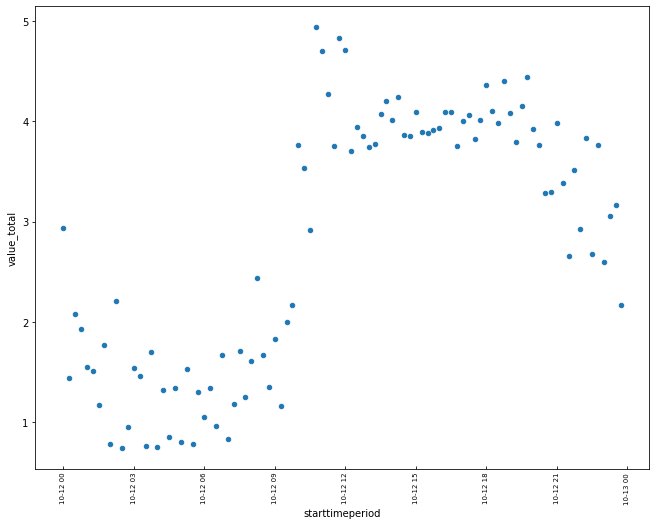

In [38]:
fig_num=0
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
df_tot[df_tot['serialnumber']==sn0].plot(ax=ax, x='starttimeperiod', y='value_total', kind='scatter')
ax.tick_params(axis='x', labelrotation=90, labelsize=7.0, direction='in');

In [39]:
df_tot.dtypes

serialnumber                           object
starttimeperiod                datetime64[ns]
endtimeperiod                  datetime64[ns]
aep_endtime_utc                         int32
timezoneoffset                timedelta64[ns]
value_delivered                       float64
value_received                        float64
value_total                           float64
endtimeperiodUTC_fromUTC       datetime64[ns]
endtimeperiodLocal_fromUTC     datetime64[ns]
dtype: object

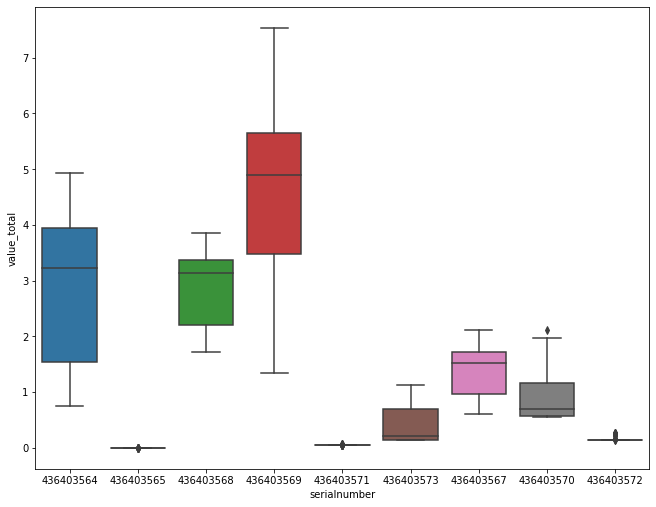

In [40]:
fig_num=0

fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.boxplot(ax=ax, x='serialnumber', y='value_total', data=df_tot)
fig_num +=1